# Exercise Form Classification — Initial Report & Exploratory Data Analysis (EDA)

This notebook:
- Loads the exercise image dataset from a folder structure
- Builds a metadata DataFrame (exercise, label, size, augmentation flag, etc.)
- Performs EDA + visualizations
- Adds a **baseline model** using metadata-only features (not image pixels)

**Expected dataset structure**
```
exercise_training_dataset/
  squat/
    correct/*.jpg
    incorrect/*.jpg
  pushup/
    correct/*.jpg
    incorrect/*.jpg
  plank/
    correct/*.jpg
    incorrect/*.jpg
  lunge/
    correct/*.jpg
    incorrect/*.jpg
```


In [19]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib pillow opencv-python scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 30.5 MB/s  0:00:011.0 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 28.3 MB/s  0:00:0023.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 22.8 MB/s  0:00:01a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-learn]0m 4/5 [scikit-learn]]


In [26]:
# 1) Imports
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option("display.max_columns", 200)


## 2) Load dataset → build metadata DataFrame

This cell scans the dataset folders and constructs a DataFrame with one row per image.


In [27]:
# Define dataset path (update this if your folder name/path is different)
DATASET_PATH = Path("exercise_training_dataset")

# Initialize list to store image metadata
image_data = []

# Define exercise types and labels
exercises = ["squat", "pushup", "plank", "lunge"]
labels = ["correct", "incorrect"]

# Load image paths and metadata
for exercise in exercises:
    for label in labels:
        folder_path = DATASET_PATH / exercise / label
        
        if folder_path.exists():
            # Get all image files (support jpg/jpeg/png)
            image_files = []
            image_files += list(folder_path.glob("*.jpg"))
            image_files += list(folder_path.glob("*.jpeg"))
            image_files += list(folder_path.glob("*.png"))
            
            for img_path in image_files:
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                    
                    file_size_kb = img_path.stat().st_size / 1024  # KB
                    
                    image_data.append({
                        "image_path": str(img_path),
                        "filename": img_path.name,
                        "exercise": exercise,
                        "label": label,
                        "width": width,
                        "height": height,
                        "file_size_kb": file_size_kb,
                        "is_augmented": ("aug" in img_path.name.lower())
                    })
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

# Create DataFrame
df = pd.DataFrame(image_data)

print("=" * 70)
print("DATASET LOADED SUCCESSFULLY")
print("=" * 70)
print(f"Total images: {len(df)}")
print(f"Dataset path: {DATASET_PATH.resolve()}")
print(f"Dataset shape: {df.shape}")
df.head()


DATASET LOADED SUCCESSFULLY
Total images: 3205
Dataset path: /Users/sikarwar/technology/workspace/ai-ml/uc-berkeley/motion-detector/notebooks/exercise_training_dataset
Dataset shape: (3205, 8)


,image_path,filename,exercise,label,width,height,file_size_kb,is_augmented
0,exercise_training_dataset/squat/correct/image_...,image_193.jpg,squat,correct,1150,1340,478.597656,False
1,exercise_training_dataset/squat/correct/image_...,image_187.jpg,squat,correct,1280,720,355.355469,False
2,exercise_training_dataset/squat/correct/image_...,image_178.jpg,squat,correct,1280,720,375.819336,False
3,exercise_training_dataset/squat/correct/image_...,image_150.jpg,squat,correct,1360,872,526.124023,False
4,exercise_training_dataset/squat/correct/image_...,image_144.jpg,squat,correct,1378,989,254.576172,False


## 3) Quick checks (types, missing values, duplicates)


In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3205 entries, 0 to 3204
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_path    3205 non-null   object 
 1   filename      3205 non-null   object 
 2   exercise      3205 non-null   object 
 3   label         3205 non-null   object 
 4   width         3205 non-null   int64  
 5   height        3205 non-null   int64  
 6   file_size_kb  3205 non-null   float64
 7   is_augmented  3205 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 178.5+ KB


In [29]:
df.isna().sum().sort_values(ascending=False)


image_path      0
filename        0
exercise        0
label           0
width           0
height          0
file_size_kb    0
is_augmented    0
dtype: int64

In [30]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 0


## 4) Basic EDA — class balance and exercise distribution


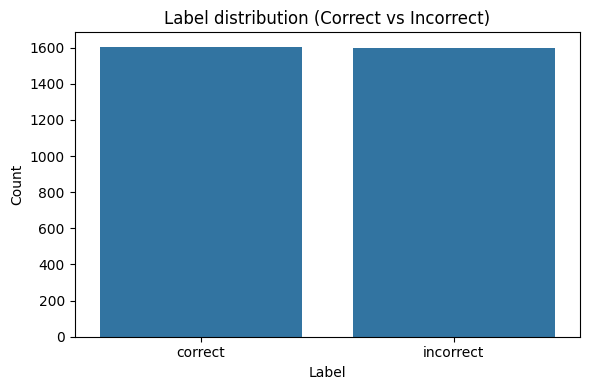

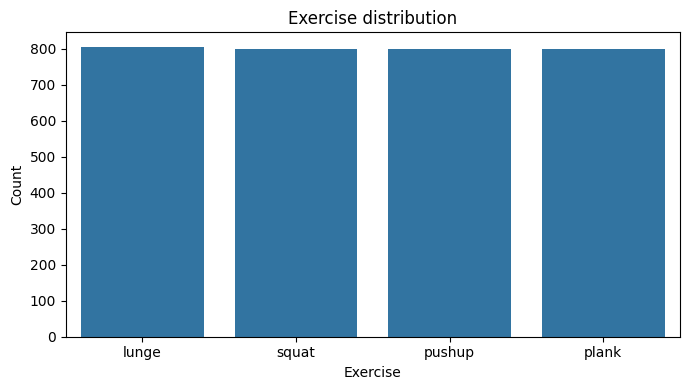

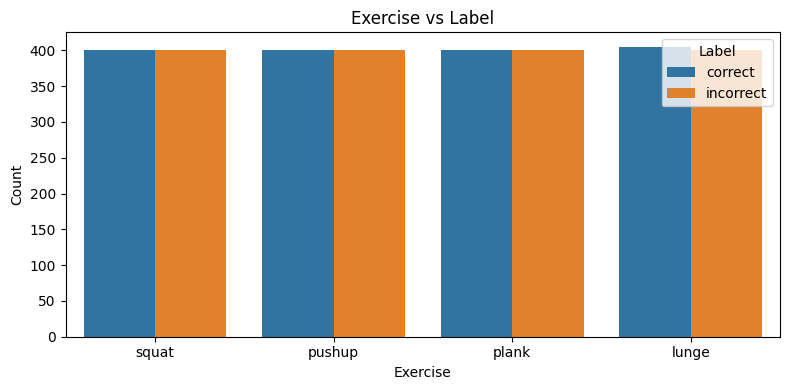

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Label distribution (Correct vs Incorrect)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.countplot(data=df, x="exercise", order=df["exercise"].value_counts().index)
plt.title("Exercise distribution")
plt.xlabel("Exercise")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="exercise", hue="label")
plt.title("Exercise vs Label")
plt.xlabel("Exercise")
plt.ylabel("Count")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


## 5) Image size & file size analysis


In [32]:
df["aspect_ratio"] = df["width"] / df["height"]
df["megapixels"] = (df["width"] * df["height"]) / 1e6

df[["width","height","aspect_ratio","file_size_kb","megapixels"]].describe()


,width,height,aspect_ratio,file_size_kb,megapixels
count,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000
mean,1235.770359,937.100156,1.398370,269.152836,1.367905
std,562.114926,452.325931,0.430162,269.977117,2.183033
min,350.000000,298.000000,0.625000,16.028320,0.141050
25%,1000.000000,687.000000,1.035443,102.910156,0.634800
50%,1280.000000,872.000000,1.436782,211.248047,1.080000
75%,1386.000000,1094.000000,1.579805,349.788086,1.541000
max,6186.000000,4514.000000,3.171141,2886.439453,27.923604


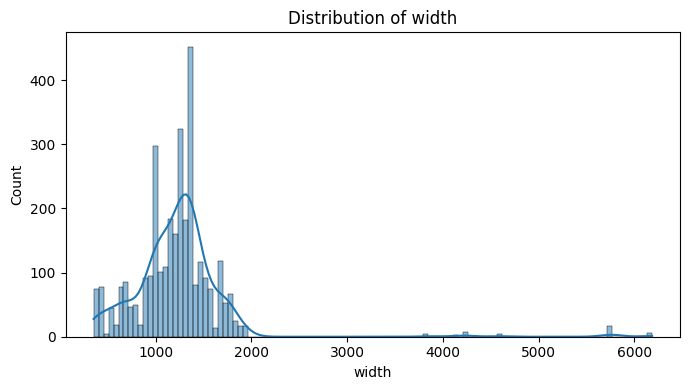

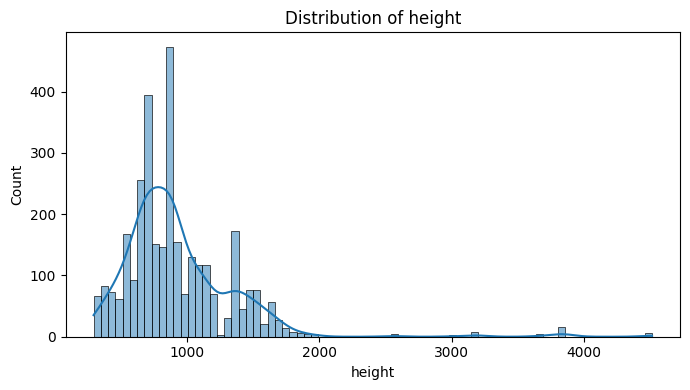

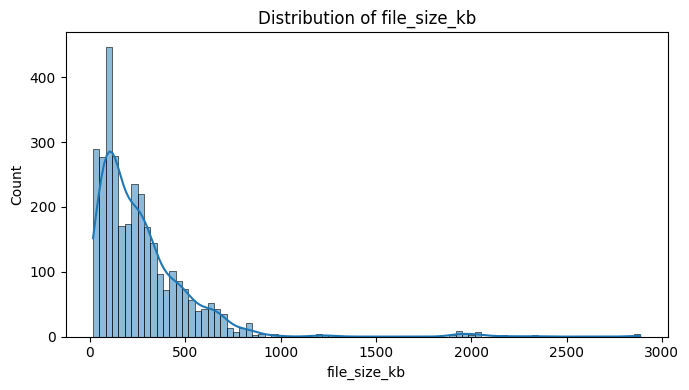

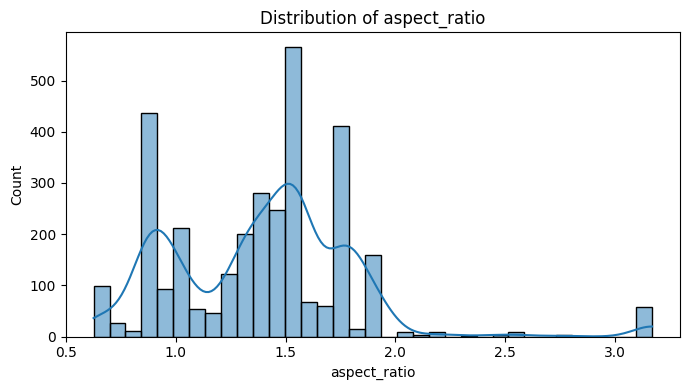

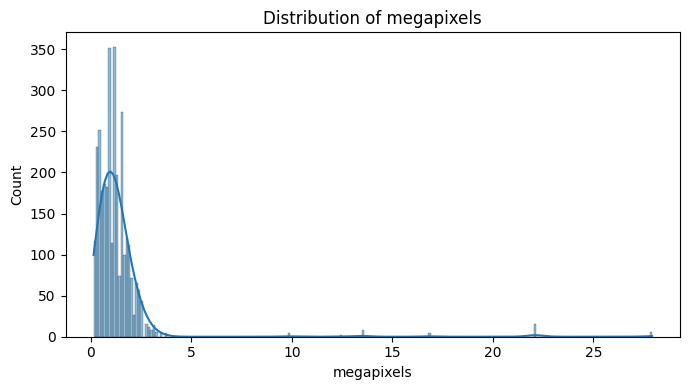

In [33]:
for col in ["width", "height", "file_size_kb", "aspect_ratio", "megapixels"]:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## 6) Augmentation check


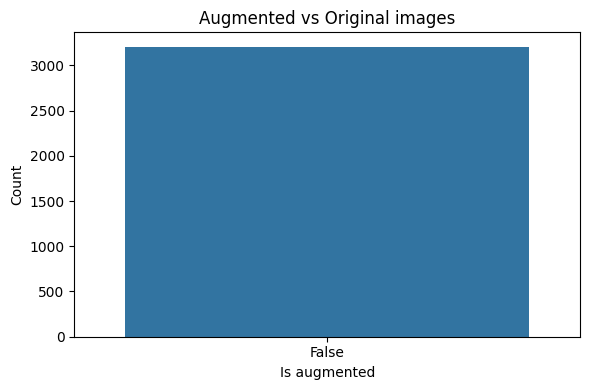

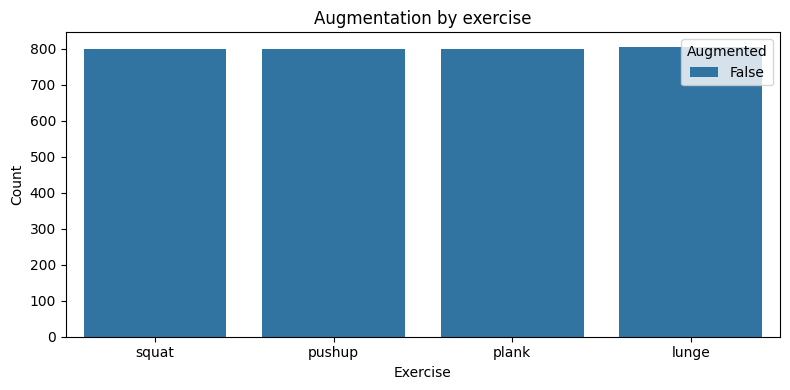

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="is_augmented")
plt.title("Augmented vs Original images")
plt.xlabel("Is augmented")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="exercise", hue="is_augmented")
plt.title("Augmentation by exercise")
plt.xlabel("Exercise")
plt.ylabel("Count")
plt.legend(title="Augmented")
plt.tight_layout()
plt.show()


## 7) Correlation heatmap (metadata-only)


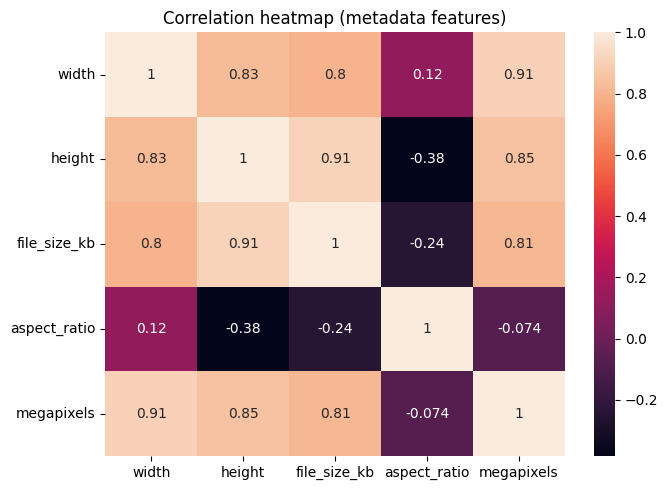

In [35]:
num_cols = ["width", "height", "file_size_kb", "aspect_ratio", "megapixels"]
plt.figure(figsize=(7,5))
sns.heatmap(df[num_cols].corr(), annot=True)
plt.title("Correlation heatmap (metadata features)")
plt.tight_layout()
plt.show()


## 8) Baseline model (metadata-only)

This is a **baseline** using only metadata (sizes, file size, exercise type, augmentation flag).
It will not be as strong as a CNN on pixels, but it satisfies the baseline-model requirement.


In [36]:
# Safety check
required_cols = {"label","exercise","width","height","file_size_kb","aspect_ratio","megapixels","is_augmented"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in df: {missing}")

# Target: correct(1) vs incorrect(0)
y = (df["label"] == "correct").astype(int)

X = df[["exercise", "width", "height", "file_size_kb", "aspect_ratio", "megapixels", "is_augmented"]]

categorical_features = ["exercise", "is_augmented"]
numeric_features = ["width", "height", "file_size_kb", "aspect_ratio", "megapixels"]

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

acc = accuracy_score(y_test, pred)
print("Baseline Accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))


Baseline Accuracy: 0.8970358814352574

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       320
           1       0.90      0.89      0.90       321

    accuracy                           0.90       641
   macro avg       0.90      0.90      0.90       641
weighted avg       0.90      0.90      0.90       641


Confusion matrix:
 [[289  31]
 [ 35 286]]


/Users/sikarwar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sikarwar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sikarwar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sikarwar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sikarwar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_point

## 9) Results summary

Run the cells below after loading the dataset. 


In [37]:
# Key dataset summary numbers
print("=== DATASET SUMMARY ===")
print("Total images:", len(df))
print("\nImages per exercise:\n", df["exercise"].value_counts())
print("\nImages per label:\n", df["label"].value_counts())
print("\nImages per (exercise, label):\n", pd.crosstab(df["exercise"], df["label"]))

# Class balance
label_counts = df["label"].value_counts()
total = label_counts.sum()
print("\nClass balance (%):")
for k, v in label_counts.items():
    print(f"  {k}: {100*v/total:.2f}%")

# Augmentation
print("\nAugmented images:", df["is_augmented"].sum())
print("Original images:", (~df["is_augmented"]).sum())


=== DATASET SUMMARY ===
Total images: 3205

Images per exercise:
 exercise
lunge     805
squat     800
pushup    800
plank     800
Name: count, dtype: int64

Images per label:
 label
correct      1605
incorrect    1600
Name: count, dtype: int64

Images per (exercise, label):
 label     correct  incorrect
exercise                    
lunge         405        400
plank         400        400
pushup        400        400
squat         400        400

Class balance (%):
  correct: 50.08%
  incorrect: 49.92%

Augmented images: 0
Original images: 3205


In [38]:
# Cleaning results (duplicates + missing)
print("=== CLEANING CHECKS ===")
print("Missing values per column (non-zero only):")
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing if len(missing) else "No missing values found in df metadata.")

print("\nDuplicate rows:", df.duplicated().sum())


=== CLEANING CHECKS ===
Missing values per column (non-zero only):
No missing values found in df metadata.

Duplicate rows: 0


In [39]:
# Outlier fractions using IQR rule (metadata numeric columns)
def iqr_outlier_fraction(series: pd.Series) -> float:
    s = series.dropna()
    if s.empty:
        return 0.0
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).mean()

num_cols = ["width", "height", "file_size_kb", "aspect_ratio", "megapixels"]
outlier_report = {col: iqr_outlier_fraction(df[col]) for col in num_cols}

print("=== OUTLIER REPORT (IQR FRACTION) ===")
for col, frac in sorted(outlier_report.items(), key=lambda x: -x[1]):
    print(f"{col}: {frac:.4f}")


=== OUTLIER REPORT (IQR FRACTION) ===
width: 0.0384
file_size_kb: 0.0318
height: 0.0268
megapixels: 0.0250
aspect_ratio: 0.0231


## 10) Baseline model result 

Below cell prints the baseline metric again in a compact way for your report text.


In [40]:
print("=== BASELINE MODEL RESULT ===")
print("Metric: Accuracy (classification baseline)")
print("Accuracy:", acc)


=== BASELINE MODEL RESULT ===
Metric: Accuracy (classification baseline)
Accuracy: 0.8970358814352574


## 11) Executive brief 


Edit the bracketed parts after you run the notebook. Keep it short and clear.


**Executive brief (edit after running):**

- **Goal:** Classify exercise form as **correct vs incorrect** across four exercises (squat, pushup, plank, lunge).
- **Dataset:** `exercise_training_dataset/` with a total of **[TOTAL_IMAGES]** images (including **[AUG_COUNT]** augmented images).
- **Data quality checks:** Missing values in metadata: **[NONE / LIST]**. Duplicate metadata rows: **[DUP_COUNT]**.
- **EDA insights:** Class balance is **[BALANCED / IMBALANCED]** with correct = **[X%]** and incorrect = **[Y%]**. Image sizes vary (see width/height distributions) and file size correlates with resolution (see correlation heatmap).
- **Outliers:** Potential anomalies exist primarily in **[COLUMN_NAMES]** (IQR outlier fractions reported above).
- **Baseline model:** A **Logistic Regression** baseline using **metadata-only** features achieved **Accuracy = [ACC]** on the test split, providing a benchmark for more advanced image-based models in the next module.
- **Next steps:** Train an image-based CNN (or transfer learning), improve preprocessing/augmentation, and compare multiple models using cross-validation.
